# Ejemplo de simulacion basada en agentes

Se utiliza un grafo simple (no el centro historico)
para poder mostrar de manera mas simplificada todas
las funcionalidades del modelo de simulacion basada en agentes.

In [1]:
import numpy as np
import math
import networkx as nx
import pandas as pd
from tqdm import tqdm
import time
import pickle
import random
import colorsys
from matplotlib.ticker import MaxNLocator
from collections import Counter
import matplotlib.colors as mcolors
import os
import pickle
import copy
from scipy.spatial.distance import pdist, squareform
import gc
import matplotlib.pyplot as plt

In [2]:
# cargar el modelo
import simulation_model
from simulation_model import Modelo

## Creacion del grafo a considerar

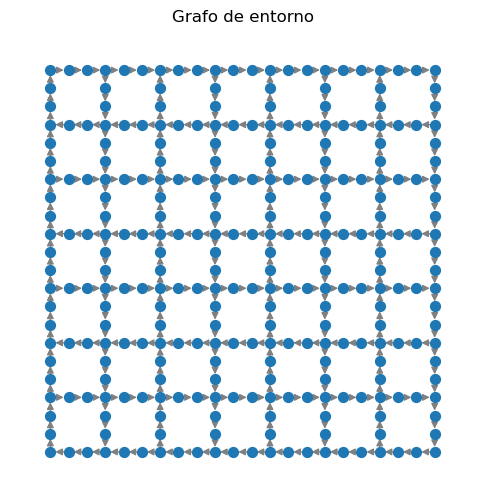

In [3]:
# hacer el grafo
G, pos = simulation_model.grafo_personalizado(lado = 11, d = 2, nodos_mitad = 5, bidireccion = False)
G, pos = simulation_model.generar_cuadricula_dirigida(22, 3)

# ver
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Grafo de entorno")
nx.draw(G, pos, ax=ax, node_size=50, edge_color = "gray", arrowsize = 10)
plt.show()

In [4]:
# definir probabilidades de origen
proba_sin_normalizar = np.array([max(x, y) for (x,y) in G.nodes()])
proba_sin_normalizar = np.array([1 for (x,y) in G.nodes()])
proba_normalizada = proba_sin_normalizar/proba_sin_normalizar.sum()
proba_origen = {nodo : proba_normalizada[idx] for idx, nodo in enumerate(G.nodes())}

# definir probabilidades de destino
proba_sin_normalizar = np.array([1/(1 + x**2 + y**2) for (x,y) in G.nodes()])
proba_sin_normalizar = np.array([1 for (x,y) in G.nodes()])
proba_normalizada = proba_sin_normalizar/proba_sin_normalizar.sum()
proba_destino = {nodo : proba_normalizada[idx] for idx, nodo in enumerate(G.nodes())}

In [5]:
# poner todo esto en un dict
info_grafo = {
    "G": G,
    "pos": pos,
    "proba_origen": proba_origen,
    "proba_destino": proba_destino
}

In [6]:
# argumentos de visualizacion
arg_visua = {
    "node_size": 50,
    "edge_color": "gray",
    "arrowsize": 10,
    "color_vacio": '#f0f0f0',
    "color_bloqueo": "red"
}

## Ejecutar el modelo de simulacion

In [7]:
# bloqueos del modelo
bloqueos = [
    {"inicio_bloqueo":5,
     "fin_bloqueo":70,
     "nodos_bloqueados": {(9, 7), (9, 8), (9, 10), (9, 11), (9, 13), (9, 14)}
     },
    {"inicio_bloqueo":50,
     "fin_bloqueo":100,
     "nodos_bloqueados": {(15, 7), (15, 8), (15, 10), (15, 11), (15, 13), (15, 14)}
     }
]

In [8]:
# funcion que para cada step da el parametro lambda de la poission que genera agentes
def lambda_generar_agentes(step_simulacion):
    return 1 # constante siempre

In [9]:
# crear
model = Modelo(info_grafo, argumentos_visualizacion = arg_visua)
# correr
model.run_model(poblacion_inicial = 50,
                lambda_tiempo = lambda_generar_agentes,
                steps_generando = 100, steps_finales = 100,
                visualizar= False, sleep= 0.001,
                ver_barra_progreso= True,
                pesos_trafico = "simple",
                tiempo_recalcular_agentes = 2,
                bloqueos = bloqueos)

Tiempos minimos:: 100%|███████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 36604.83it/s]


In [10]:
# salvar los resultados (para visualizarlos despues)
model.salvar_modelo(folder_path = "./Info_simulacion_simple/")

## Visualizar resultados

In [11]:
# obtener df con info
results = model.datacollector.get_model_vars_dataframe()
results.head()

,Numero de agentes,Agentes esperando
0,50,0
1,51,5
2,52,5
3,53,4
4,54,6


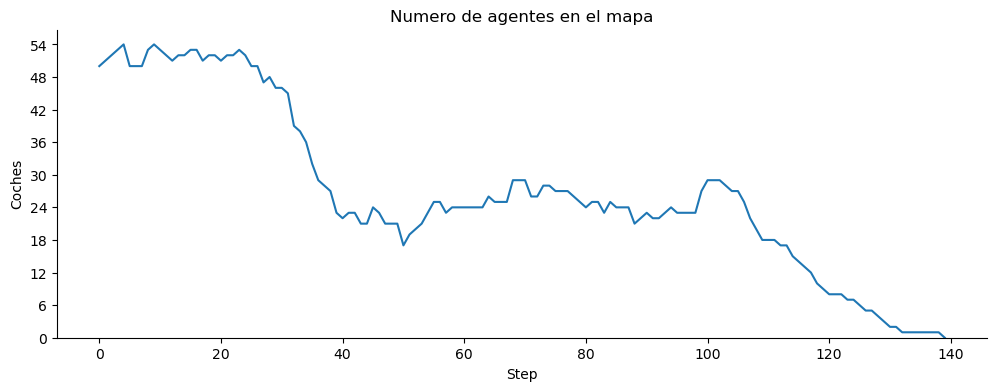

In [12]:
# ver numero de agentes en el mapa
fig, ax = plt.subplots(figsize=(12, 4))
model.mostrar_agentes_presentes(ax=ax)
plt.show()

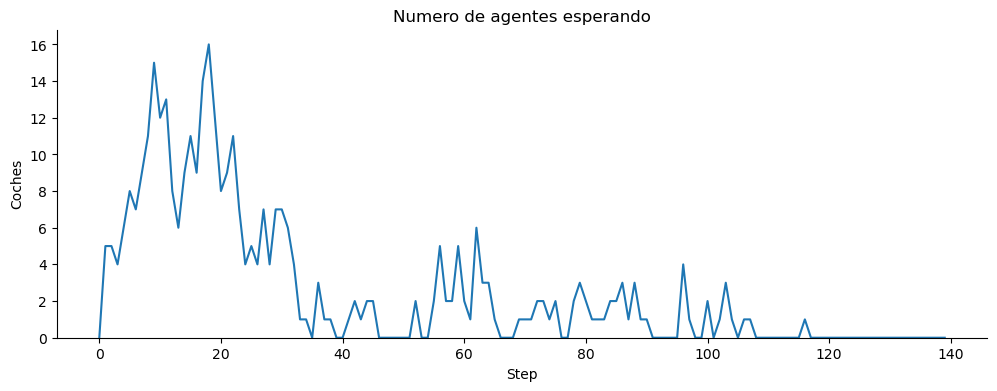

In [13]:
# ver numero de agentes esperando en cada momento
fig, ax = plt.subplots(figsize=(12, 4))
model.mostrar_agentes_esperando(ax=ax)
plt.show()

In [14]:
# diccionario con todos los agentes creados
numero_agentes = len(model.historico_agentes)
print(f"Se crearon {numero_agentes} agentes")

Se crearon 144 agentes


In [15]:
# ver info
model.imprimir_estadisticas_tiempos_agentes()

Informacion de los 144 agentes que llegaron a su destino
Tiempo minimo promedio: 21.132
Tiempo real promedio: 24.590
Porcentaje promedio de retraso: 17.515%
Promedio de veces que un agente recalcula: 5.986
Porcentaje promedio de recálculos inútiles: 91.278%


In [17]:
# tomar un agente arbitrario
agent = model.historico_agentes[10]

# ver info
print(f"El agente aparece en el step: {agent.step_creation}")
print(f"Tiempo minimo que toma su recorrido: {agent.tiempo_minimo:.3f}")
print(f"Tiempo que tomó al hacer el recorrido: {agent.tiempo_real:.3f}")
print(f"Porcentaje de retraso: {(100 * agent.tiempo_real / agent.tiempo_minimo - 100):.3f}%")
print(f"Número de veces que recalcula su camino: {agent.num_recalculadas}")
if agent.num_recalculadas != 0:
    print(f"Porcenaje de recalculos inutiles: {(100*agent.num_recalculadas_inutiles/ agent.num_recalculadas):.3f}%")

El agente aparece en el step: 0
Tiempo minimo que toma su recorrido: 19.000
Tiempo que tomó al hacer el recorrido: 19.000
Porcentaje de retraso: 0.000%
Número de veces que recalcula su camino: 4
Porcenaje de recalculos inutiles: 100.000%


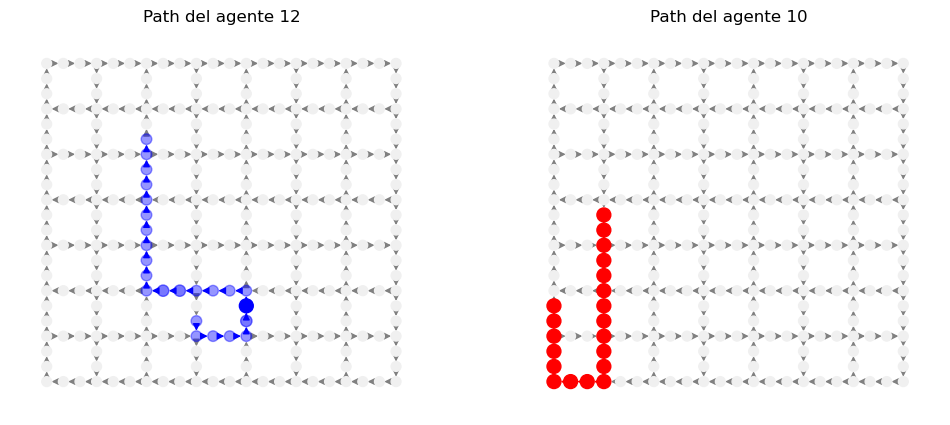

In [18]:
# graficar el path de agentes
idx_agente1 = 12
idx_agente2 = 10

fig, ax  = plt.subplots(1, 2, figsize=(12, 5))
model.dibujar_path(model.historico_agentes[idx_agente1].path, ax=ax[0], color_path = "blue", alpha_min = 0.3)
model.dibujar_path(model.historico_agentes[idx_agente2].path, ax=ax[1], color_path = "red", alpha_min = 0.3)
ax[0].set_title(f"Path del agente {idx_agente1}")
ax[1].set_title(f"Path del agente {idx_agente2}")
plt.show()

In [19]:
# ver centralidades de los nodos
df_centr_nodos, df_centr_edges = model.obtener_centralidades_df()

In [20]:
# centralidades de nodos
df_centr_nodos.head()

,node,centralidad
94,"(6, 18)",37
167,"(12, 15)",32
104,"(7, 18)",31
66,"(4, 18)",30
205,"(15, 15)",29


In [21]:
# centralidades de aristas
df_centr_edges.head()

,edges,centralidad
54,"((3, 10), (3, 9))",22
110,"((6, 18), (5, 18))",22
55,"((3, 11), (3, 10))",22
84,"((5, 18), (4, 18))",21
63,"((3, 17), (3, 16))",20


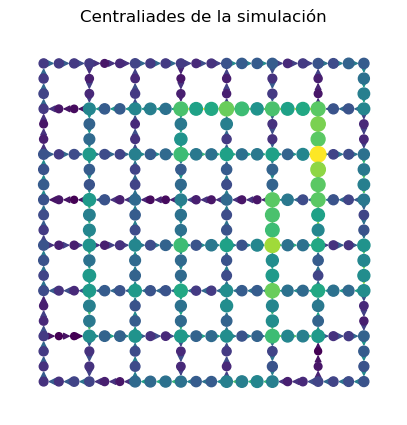

In [22]:
# visualizarlas
fig, ax  = plt.subplots(figsize=(5, 5))
model.dibujar_centralidades(ax=ax)
ax.set_title("Centraliades de la simulación")
plt.show()

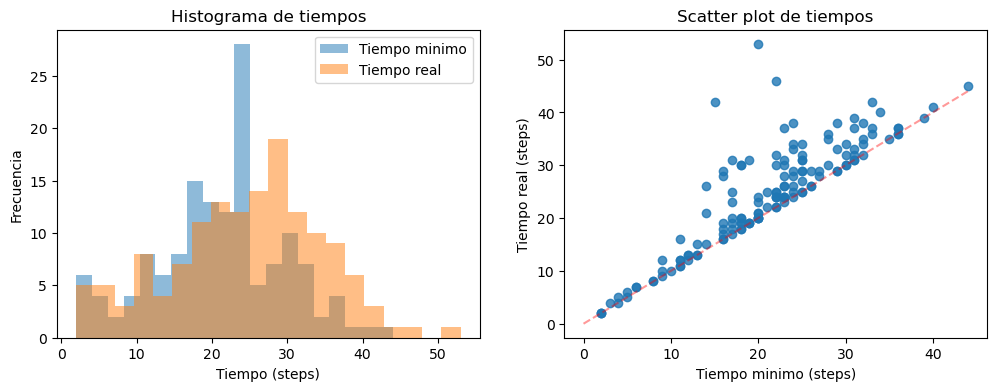

In [23]:
# ver los tiempos reales y optimos de los agentes
model.graficar_tiempos_agentes(alpha_hist = 0.5, alpha_scatter = 0.8)